sqrt {'n_estimators': 9}
log2 {'n_estimators': 9}
None {'n_estimators': 9}


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


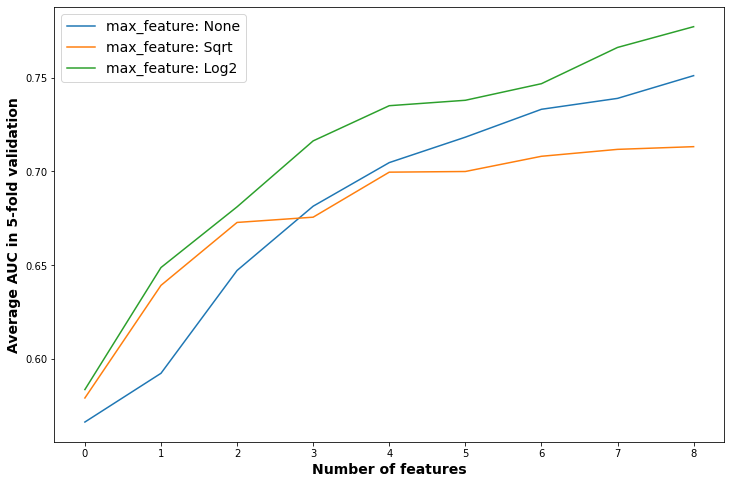

entropy {'n_estimators': 9}
gini {'n_estimators': 9}


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


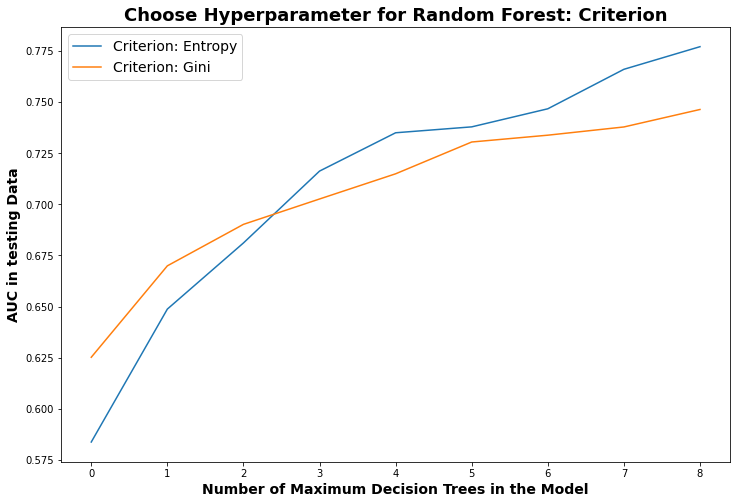

AUC for testing Data is:  0.871764705882353
              precision    recall  f1-score   support

     class 1       0.84      0.86      0.85       100
     class 2       0.71      0.69      0.70        51

    accuracy                           0.80       151
   macro avg       0.78      0.77      0.78       151
weighted avg       0.80      0.80      0.80       151

*****Training Data Performance*****
AUC for testing Data is:  0.9998940017458536
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00       729
     class 2       0.99      0.99      0.99       220

    accuracy                           1.00       949
   macro avg       0.99      0.99      0.99       949
weighted avg       1.00      1.00      1.00       949



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


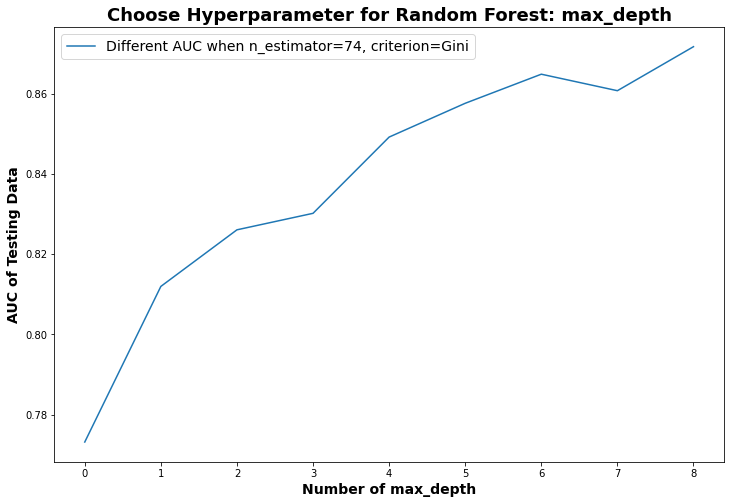

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans.


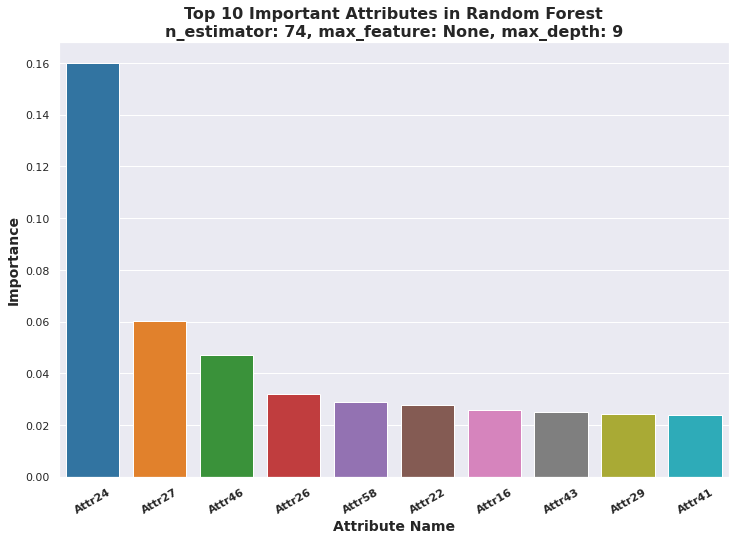

findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans.


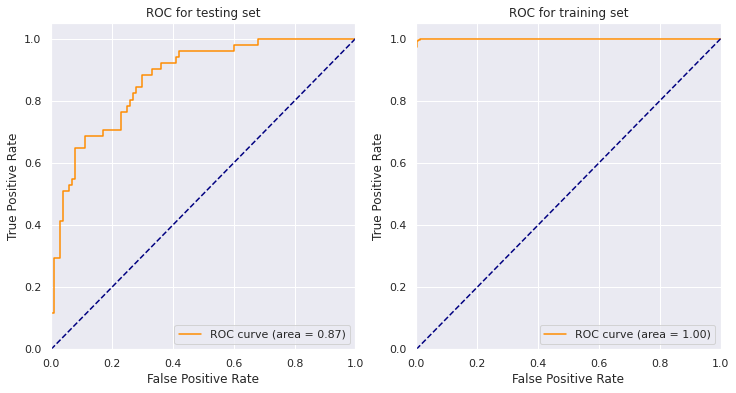

In [2]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
class Randomforest():
    def __init__(self):
        self.dataLoad()
        self.report=False
        self.train_test = False
        self.score_record = {}

    def dataLoad(self):
        train_set = pd.read_csv("../data/imp_train.csv")
        test_set = pd.read_csv("../data/imp_test.csv")
        self.training_data = train_set.drop(columns = ["class", 'Attr14', 'Attr18'])
        self.training_label = train_set["class"]
        self.testing_data = test_set.drop(columns = ["class", 'Attr14', 'Attr18'])
        self.testing_label = test_set["class"]
        with open("../data/features_meaning.txt") as f:
            self.features_meaning = f.readlines()

    def train(self, max_estimators=10):
        param_grid = {'n_estimators': range(1, max_estimators, 1)}
        for feature in ["sqrt", "log2", None]:
            forest_reg = RandomForestClassifier(max_features=feature, criterion="entropy", random_state=119020)
            grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                                    scoring='roc_auc', n_jobs=3, return_train_score=True)
            grid_search.fit(self.training_data, self.training_label)
            print(feature, grid_search.best_params_)
            self.score_record[feature] = pd.DataFrame(grid_search.cv_results_)["mean_test_score"]
            self.test(grid_search.best_params_["n_estimators"], feature)

    def train_criterion(self, max_estimators=10):
        param_grid = {'n_estimators': range(1, max_estimators, 1)}
        for criterion in ["entropy", "gini"]:
            forest_reg = RandomForestClassifier(max_features=None, criterion=criterion, random_state=119020)
            grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                                    scoring='roc_auc', n_jobs=3, return_train_score=True)
            grid_search.fit(self.training_data, self.training_label)
            print(criterion, grid_search.best_params_)
            self.score_record[criterion] = pd.DataFrame(grid_search.cv_results_)["mean_test_score"]
            self.test(grid_search.best_params_["n_estimators"], None, criterion)

    def train_maxDepth(self, max_depth=30):
        depthLst = []
        for max_depth in range(1, max_depth, 1):
            self.test(74, None, "gini", max_depth)
            depthLst.append(self.auc)
        self.score_record["max_depth"] = depthLst

    def test(self, estimators, features, mycriterion="gini", max_depth=None):
        self.classifier = RandomForestClassifier(n_estimators = estimators, criterion = mycriterion,
            max_features=features, random_state = 119020, max_depth=max_depth)
        self.classifier.fit(self.training_data, self.training_label)
        self.max_depth = max_depth
        # Predicting the Test set results
        if self.train_test:
            print("*****Training Data Performance*****")
            self.testing_data = self.training_data
            self.testing_label = self.training_label
        y_pred = np.array([1]*self.testing_label.shape[0])
        # y_pred = self.classifier.predict(self.testing_data)
        y_pred1 = self.classifier.predict_proba(self.testing_data)[:,1]
        y_pred[y_pred1<0.33] = 0
        self.auc = roc_auc_score(self.testing_label, y_pred1)
        self.estimators = estimators
        self.features = features
        target_names = ['class 1', 'class 2']
        result = classification_report(np.array(self.testing_label), y_pred, target_names=target_names)
        if self.report:
            print("AUC for testing Data is: ", self.auc)
            print(result)
        if self.train_test:
            self.dataLoad()
            self.train_test = False
    
    def visualize_criterion(self):
        plt.figure(figsize=(12, 8))
        plt.plot(pd.DataFrame(self.score_record))
        plt.legend(["Criterion: Entropy","Criterion: Entropy"], fontsize=14)
        plt.xlabel("Number of features",  font = {'family': 'normal', 'weight': 'bold', 'size': 14})
        plt.ylabel("Average AUC in 5-fold validation", font = {'family' : 'normal', 'weight' : 'bold', 'size': 14})

    def visualize_maxDepth(self):
        plt.figure(figsize=(12, 8))
        plt.plot(pd.DataFrame(self.score_record))
        plt.legend(["Different AUC when n_estimator=74, criterion=Gini"], fontsize=14)
        plt.xlabel("Number of max_depth",  font = {'family': 'normal', 'weight': 'bold', 'size': 14})
        plt.title("Choose Hyperparameter for Random Forest: max_depth", font = {'family' : 'normal', 'weight' : 'bold', 'size': 18})
        plt.ylabel("AUC of Testing Data", font = {'family' : 'normal', 'weight' : 'bold', 'size': 14})

    def visualize(self):
        plt.figure(figsize=(12, 8))
        plt.plot(pd.DataFrame(self.score_record))
        plt.legend(["max_feature: None","max_feature: Sqrt","max_feature: Log2"], fontsize=14)
        plt.xlabel("Number of features",  font = {'family': 'normal', 'weight': 'bold', 'size': 14})
        plt.ylabel("Average AUC in 5-fold validation", font = {'family' : 'normal', 'weight' : 'bold', 'size': 14})
        plt.show()
        self.score_record = {}
    
    def visualize_feature(self):
        plt.figure(figsize=(12, 8))
        plt.plot(pd.DataFrame(self.score_record))
        plt.legend(["Criterion: Entropy","Criterion: Gini"], fontsize=14)
        plt.xlabel("Number of Maximum Decision Trees in the Model",  font = {'family': 'normal', 'weight': 'bold', 'size': 14})
        plt.title("Choose Hyperparameter for Random Forest: Criterion", font = {'family' : 'normal', 'weight' : 'bold', 'size': 18})
        plt.ylabel("AUC in testing Data", font = {'family' : 'normal', 'weight' : 'bold', 'size': 14})
        plt.show()
        self.score_record = {}

    def tree_visualize(self):
        important_attr = pd.DataFrame([self.training_data.columns, self.classifier.feature_importances_]).T.sort_values(by=[1], ascending=False).head(10)
        sns.set_theme(style="darkgrid",font="Microsoft YaHei",palette=sns.color_palette("tab10"))
        plt.figure(figsize=(12,8))
        ax = sns.barplot(x=0, y=1, data=important_attr)
        ax.set_title("Top 10 Important Attributes in Random Forest\nn_estimator: {}, max_feature: {}, max_depth: {}".format(self.estimators,self.features, self.max_depth), \
            fontdict={"family": "normal", "weight": "bold", "size": 16})
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 30, fontdict={"family": "normal", "weight": "bold"})
        ax.set_xlabel("Attribute Name", fontdict={"family": "normal", "weight": "bold", "size": 14})
        ax.set_ylabel("Importance", fontdict={"family": "normal", "weight": "bold", "size": 14})
    
    def draw_roc(self):
        score = self.classifier.predict_proba(self.testing_data)[:,1]
        auc = roc_auc_score(self.testing_label, score)
        fpr, tpr, _ = roc_curve(self.testing_label, score)
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.plot(fpr, tpr, color='darkorange',
                label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for testing set')
        plt.legend(loc="lower right")

        score = self.classifier.predict_proba(self.training_data)[:,1]
        auc = roc_auc_score(self.training_label, score)
        fpr, tpr, _ = roc_curve(self.training_label, score)
        plt.subplot(122)
        plt.plot(fpr, tpr, color='darkorange',
                label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for training set')
        plt.legend(loc="lower right")
        plt.show()


if __name__=="__main__":
    p=Randomforest()
    p.train(100)
    p.visualize()
    p.train_criterion(80)
    p.visualize_feature()
    p.train_maxDepth(40)
    p.visualize_maxDepth()
    p.report=True
    p.train_test = False
    p.test(estimators=74, features=None, mycriterion="gini", max_depth=9)
    p.train_test = True
    p.test(estimators=74, features=None, mycriterion="gini", max_depth=9)
    p.tree_visualize()
    p.draw_roc()